In [1]:
!pip install segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.9 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 35.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 15.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 5.7 MB/s eta 0:00:000:00:0100:01
  Attempting uninsta

In [2]:
import os
import glob
import random
from PIL import Image
import tifffile

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.metrics import iou_score, f1_score
from tqdm import tqdm

import albumentations as A
from albumentations.pytorch import ToTensorV2

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [3]:
class LGGDataset(Dataset):
    def __init__(self, dirs, transform=None):
        self.samples = []
        self.transform = transform

        for patient_dir in dirs:            
            images = [os.path.join(patient_dir, img) for img in os.listdir(patient_dir) if "_mask.tif" not in img]

            for img in images:
                mask_path = img.replace(".tif", "_mask.tif")

                image = tifffile.imread(img).astype(np.float32) / 255.0
                mask = tifffile.imread(mask_path).astype(np.float32) / 255.0

                augmented = self.transform(image=image, mask=mask)
                image = augmented["image"]
                mask = augmented["mask"]

                mask = torch.tensor(mask).unsqueeze(0).float()
                
                self.samples.append((image, mask))
                

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img, mask = self.samples[idx]
        return img, mask


In [4]:
root = "/kaggle/input/lgg-mri-segmentation/kaggle_3m/"

patients = sorted([os.path.join(root, p) for p in os.listdir(root)])
patients = [patient for patient in patients if os.path.isdir(patient)]
random.shuffle(patients)

train_patients = patients[:90]
val_patients = patients[90:]

# train_transform = A.Compose([
#     A.ChannelDropout(p=0.3),
#     A.RandomBrightnessContrast(p=0.3),
#     A.ColorJitter(p=0.3),
#     ToTensorV2()
# ])
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.RandomRotate90(p=0.5),
    A.Affine(
        translate_percent=(0.05, 0.05),
        scale=(0.95, 1.05),
        rotate=(-20, 20),
        p=0.5
    ),
    A.ElasticTransform(alpha=50, sigma=50, p=0.3),
    A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.3),
    A.RandomBrightnessContrast(p=0.3),
    #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])


val_transform = A.Compose([
    ToTensorV2()
])

#train_ds = LGGDataset(train_patients)
#val_ds = LGGDataset(val_patients)

train_ds = LGGDataset(train_patients, train_transform)
val_ds = LGGDataset(val_patients, val_transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

/tmp/ipykernel_47/40135583.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask).unsqueeze(0).float()


In [5]:
models = {
    "unet_resnet34": smp.Unet(
        encoder_name='resnet34',
        encoder_weights="imagenet",
        in_channels=3,
        classes=1,
        activation=None,
    ),
    "unet_efficientnet-b0": smp.Unet(
        encoder_name='efficientnet-b0',
        encoder_weights="imagenet",
        in_channels=3,
        classes=1,
        activation=None,
    ),
    "unet_vgg16": smp.Unet(
        encoder_name='vgg16',
        encoder_weights="imagenet",
        in_channels=3,
        classes=1,
        activation=None,
    ),
}

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/553M [00:00<?, ?B/s]

In [6]:
class DiceBCELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.dice = smp.losses.DiceLoss(mode="binary")
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, pred, target):
        return self.dice(pred, target) + self.bce(pred, target)

In [7]:
metrics = {'unet_resnet34':[],'unet_efficientnet-b0':[],'unet_vgg16':[]}
#metrics = {'unet_efficientnet-b7':[]}

In [8]:
device = "cuda"


for name, model in models.items():
    model.to(device)

    #dice_loss = smp.losses.DiceLoss(mode="binary")
    dice_loss = DiceBCELoss()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',         
    factor=0.5,         
    patience=2
)
    print("\nTraining:", name)
    for epoch in range(25):
#train
        model.train()
        total = 0
        
        loop = tqdm(train_loader, desc=f"Epoch {epoch} [Train]", leave=False)
        for img, mask in loop:
            
            img, mask = img.to(device), mask.to(device)
    
            pred = model(img)
            loss = dice_loss(pred, mask)
    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            total += loss.item()
#val
        model.eval()
        losses = []
        ious = []
        dices = []
    
        loop_val = tqdm(val_loader, desc=f"Epoch {epoch} [Val]", leave=False)
        for img, mask in loop_val:
            img, mask = img.to(device), mask.to(device)
    
            pred = model(img)
            loss = dice_loss(pred, mask)

            tp, fp, fn, tn = smp.metrics.get_stats(pred, mask.int(), mode='binary', threshold=0.5)
            iou = iou_score(tp, fp, fn, tn, reduction="micro")
            dice = f1_score(tp, fp, fn, tn, reduction="micro")
    
            losses.append(loss.item())
            ious.append(iou.item())
            dices.append(dice.item())

        print(
            f"Epoch {epoch:02d} | "
            f"train_loss={total / len(train_loader):.4f} | "
            f"val_loss={np.mean(losses):.4f} | "
            f"IoU={np.nanmean(ious):.4f} | "
            f"Dice={np.nanmean(dices):.4f} | "
            f"lr={scheduler.get_last_lr()}"
        )
        metrics[name].append((total / len(train_loader), np.mean(losses), np.nanmean(ious), np.nanmean(dices)))

        scheduler.step(np.mean(losses))


Training: unet_resnet34


Epoch 00 | train_loss=0.7998 | val_loss=0.6800 | IoU=0.0000 | Dice=0.0000 | lr=[0.005]


Epoch 01 | train_loss=0.6416 | val_loss=0.6872 | IoU=0.2929 | Dice=0.4206 | lr=[0.005]


Epoch 02 | train_loss=0.5540 | val_loss=0.5678 | IoU=0.3991 | Dice=0.5379 | lr=[0.005]


Epoch 03 | train_loss=0.5324 | val_loss=0.4719 | IoU=0.4849 | Dice=0.6294 | lr=[0.005]


Epoch 04 | train_loss=0.4705 | val_loss=0.4588 | IoU=0.4801 | Dice=0.6265 | lr=[0.005]


Epoch 05 | train_loss=0.4617 | val_loss=0.4480 | IoU=0.4683 | Dice=0.6289 | lr=[0.005]


Epoch 06 | train_loss=0.3972 | val_loss=0.4623 | IoU=0.4458 | Dice=0.6047 | lr=[0.005]


Epoch 07 | train_loss=0.3961 | val_loss=0.4761 | IoU=0.4245 | Dice=0.5783 | lr=[0.005]


Epoch 08 | train_loss=0.3746 | val_loss=0.4071 | IoU=0.4912 | Dice=0.6429 | lr=[0.005]


Epoch 09 | train_loss=0.3574 | val_loss=0.4486 | IoU=0.4537 | Dice=0.5962 | lr=[0.005]


Epoch 10 | train_loss=0.3714 | val_loss=0.5421 | IoU=0.3787 | Dice=0.4994 | lr=[0.005]


Epoch 11 | train_loss=0.3556 | val_loss=0.4630 | IoU=0.4403 | Dice=0.5780 | lr=[0.005]


Epoch 12 | train_loss=0.3239 | val_loss=0.3819 | IoU=0.5146 | Dice=0.6540 | lr=[0.0025]


Epoch 13 | train_loss=0.3117 | val_loss=0.3781 | IoU=0.5185 | Dice=0.6591 | lr=[0.0025]


Epoch 14 | train_loss=0.2989 | val_loss=0.4039 | IoU=0.4966 | Dice=0.6320 | lr=[0.0025]


Epoch 15 | train_loss=0.2746 | val_loss=0.3500 | IoU=0.5447 | Dice=0.6835 | lr=[0.0025]


Epoch 16 | train_loss=0.2859 | val_loss=0.3205 | IoU=0.5737 | Dice=0.7151 | lr=[0.0025]


Epoch 17 | train_loss=0.2843 | val_loss=0.3543 | IoU=0.5445 | Dice=0.6822 | lr=[0.0025]


Epoch 18 | train_loss=0.3010 | val_loss=0.3895 | IoU=0.5152 | Dice=0.6438 | lr=[0.0025]


Epoch 19 | train_loss=0.2859 | val_loss=0.3355 | IoU=0.5599 | Dice=0.7004 | lr=[0.0025]


Epoch 20 | train_loss=0.2541 | val_loss=0.3385 | IoU=0.5609 | Dice=0.6941 | lr=[0.00125]


Epoch 21 | train_loss=0.2500 | val_loss=0.3784 | IoU=0.5210 | Dice=0.6576 | lr=[0.00125]


Epoch 22 | train_loss=0.2406 | val_loss=0.3163 | IoU=0.5817 | Dice=0.7152 | lr=[0.00125]


Epoch 23 | train_loss=0.2572 | val_loss=0.3215 | IoU=0.5738 | Dice=0.7092 | lr=[0.00125]


Epoch 24 | train_loss=0.2364 | val_loss=0.3215 | IoU=0.5787 | Dice=0.7114 | lr=[0.00125]

Training: unet_efficientnet-b0


Epoch 00 | train_loss=0.4958 | val_loss=1.3382 | IoU=0.1377 | Dice=0.2225 | lr=[0.005]


Epoch 01 | train_loss=0.3297 | val_loss=0.6283 | IoU=0.3201 | Dice=0.4180 | lr=[0.005]


Epoch 02 | train_loss=0.3087 | val_loss=0.4614 | IoU=0.4509 | Dice=0.5836 | lr=[0.005]


Epoch 03 | train_loss=0.2882 | val_loss=0.4155 | IoU=0.4925 | Dice=0.6227 | lr=[0.005]


Epoch 04 | train_loss=0.2686 | val_loss=0.3922 | IoU=0.5163 | Dice=0.6483 | lr=[0.005]


Epoch 05 | train_loss=0.2400 | val_loss=0.2424 | IoU=0.6565 | Dice=0.7876 | lr=[0.005]


Epoch 06 | train_loss=0.2359 | val_loss=0.2815 | IoU=0.6178 | Dice=0.7554 | lr=[0.005]


Epoch 07 | train_loss=0.2342 | val_loss=0.2631 | IoU=0.6366 | Dice=0.7714 | lr=[0.005]


Epoch 08 | train_loss=0.2129 | val_loss=0.2417 | IoU=0.6608 | Dice=0.7897 | lr=[0.005]


Epoch 09 | train_loss=0.2204 | val_loss=0.2510 | IoU=0.6456 | Dice=0.7808 | lr=[0.005]


Epoch 10 | train_loss=0.1982 | val_loss=0.3610 | IoU=0.5420 | Dice=0.6970 | lr=[0.005]


Epoch 11 | train_loss=0.2134 | val_loss=0.2589 | IoU=0.6400 | Dice=0.7752 | lr=[0.005]


Epoch 12 | train_loss=0.1855 | val_loss=0.2006 | IoU=0.7053 | Dice=0.8229 | lr=[0.0025]


Epoch 13 | train_loss=0.1618 | val_loss=0.2631 | IoU=0.6323 | Dice=0.7659 | lr=[0.0025]


Epoch 14 | train_loss=0.1442 | val_loss=0.4101 | IoU=0.4946 | Dice=0.6357 | lr=[0.0025]


Epoch 15 | train_loss=0.1527 | val_loss=0.2159 | IoU=0.6898 | Dice=0.8112 | lr=[0.0025]


Epoch 16 | train_loss=0.1307 | val_loss=0.2177 | IoU=0.6844 | Dice=0.8085 | lr=[0.00125]


Epoch 17 | train_loss=0.1204 | val_loss=0.1951 | IoU=0.7143 | Dice=0.8294 | lr=[0.00125]


Epoch 18 | train_loss=0.1242 | val_loss=0.1959 | IoU=0.7128 | Dice=0.8276 | lr=[0.00125]


Epoch 19 | train_loss=0.1155 | val_loss=0.1925 | IoU=0.7157 | Dice=0.8306 | lr=[0.00125]


Epoch 20 | train_loss=0.1106 | val_loss=0.1950 | IoU=0.7171 | Dice=0.8311 | lr=[0.00125]


Epoch 21 | train_loss=0.1127 | val_loss=0.1889 | IoU=0.7219 | Dice=0.8339 | lr=[0.00125]


Epoch 22 | train_loss=0.1050 | val_loss=0.1984 | IoU=0.7100 | Dice=0.8255 | lr=[0.00125]


Epoch 23 | train_loss=0.1078 | val_loss=0.1962 | IoU=0.7154 | Dice=0.8290 | lr=[0.00125]


Epoch 24 | train_loss=0.1052 | val_loss=0.1918 | IoU=0.7170 | Dice=0.8306 | lr=[0.00125]

Training: unet_vgg16


Epoch 00 | train_loss=0.7900 | val_loss=1.0695 | IoU=0.0038 | Dice=0.0073 | lr=[0.005]


Epoch 01 | train_loss=0.6067 | val_loss=0.7110 | IoU=0.2161 | Dice=0.3193 | lr=[0.005]


Epoch 02 | train_loss=0.5858 | val_loss=0.5163 | IoU=0.4042 | Dice=0.5399 | lr=[0.005]


Epoch 03 | train_loss=0.5722 | val_loss=1.0416 | IoU=0.0144 | Dice=0.0271 | lr=[0.005]


Epoch 04 | train_loss=0.5986 | val_loss=0.5526 | IoU=0.3795 | Dice=0.5223 | lr=[0.005]


Epoch 05 | train_loss=0.5607 | val_loss=0.5826 | IoU=0.4236 | Dice=0.5654 | lr=[0.005]


Epoch 06 | train_loss=0.5505 | val_loss=0.4639 | IoU=0.4389 | Dice=0.5796 | lr=[0.0025]


Epoch 07 | train_loss=0.5452 | val_loss=0.6647 | IoU=0.2741 | Dice=0.3733 | lr=[0.0025]


Epoch 08 | train_loss=0.5292 | val_loss=0.7010 | IoU=0.2580 | Dice=0.3506 | lr=[0.0025]


Epoch 09 | train_loss=0.5222 | val_loss=0.4963 | IoU=0.4109 | Dice=0.5446 | lr=[0.0025]


Epoch 10 | train_loss=0.4920 | val_loss=0.6489 | IoU=0.2741 | Dice=0.4006 | lr=[0.00125]


Epoch 11 | train_loss=0.4908 | val_loss=1.0050 | IoU=0.0243 | Dice=0.0442 | lr=[0.00125]


Epoch 12 | train_loss=0.4819 | val_loss=0.5465 | IoU=0.3680 | Dice=0.4977 | lr=[0.00125]


Epoch 13 | train_loss=0.4506 | val_loss=0.4490 | IoU=0.4583 | Dice=0.5976 | lr=[0.000625]


Epoch 14 | train_loss=0.4420 | val_loss=0.5698 | IoU=0.3408 | Dice=0.4690 | lr=[0.000625]


Epoch 15 | train_loss=0.4426 | val_loss=0.6132 | IoU=0.3070 | Dice=0.4329 | lr=[0.000625]


Epoch 16 | train_loss=0.4337 | val_loss=0.5425 | IoU=0.3636 | Dice=0.4969 | lr=[0.000625]


Epoch 17 | train_loss=0.4340 | val_loss=0.4862 | IoU=0.4210 | Dice=0.5542 | lr=[0.0003125]


Epoch 18 | train_loss=0.4247 | val_loss=0.4899 | IoU=0.4121 | Dice=0.5484 | lr=[0.0003125]


Epoch 19 | train_loss=0.4271 | val_loss=0.4725 | IoU=0.4300 | Dice=0.5663 | lr=[0.0003125]


Epoch 20 | train_loss=0.4152 | val_loss=0.4537 | IoU=0.4452 | Dice=0.5837 | lr=[0.00015625]


Epoch 21 | train_loss=0.4073 | val_loss=0.4798 | IoU=0.4218 | Dice=0.5590 | lr=[0.00015625]


Epoch 22 | train_loss=0.4184 | val_loss=0.4907 | IoU=0.4084 | Dice=0.5465 | lr=[0.00015625]


Epoch 23 | train_loss=0.4122 | val_loss=0.4933 | IoU=0.4069 | Dice=0.5443 | lr=[7.8125e-05]


Epoch 24 | train_loss=0.4153 | val_loss=0.4848 | IoU=0.4145 | Dice=0.5526 | lr=[7.8125e-05]


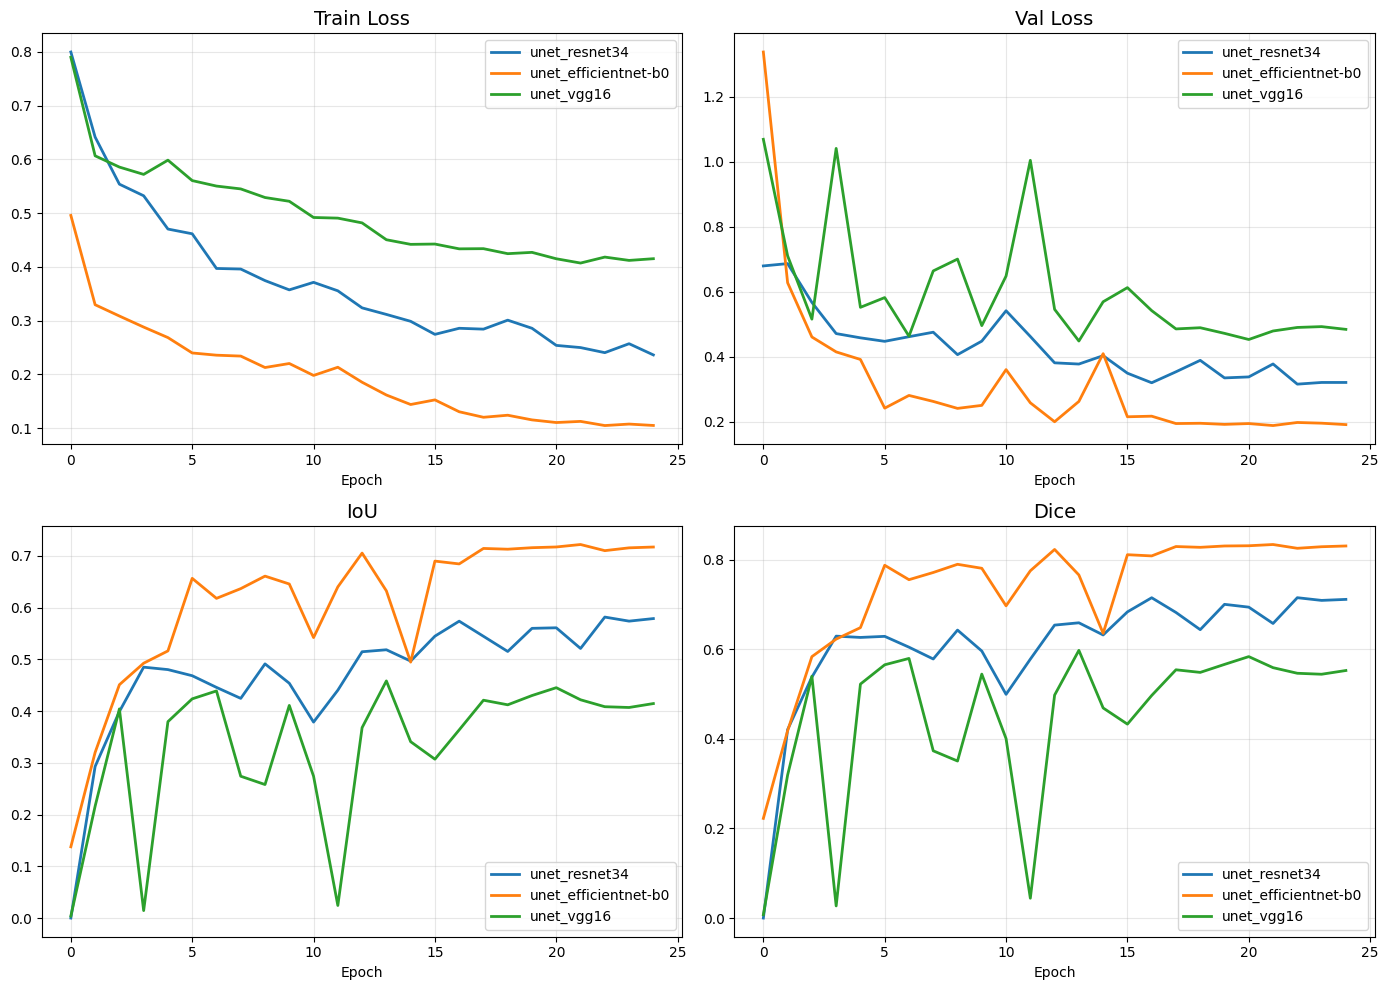

In [9]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.ravel()

titles = ["Train Loss", "Val Loss", "IoU", "Dice"]
metric_idx = [0, 1, 2, 3]

for ax, title, idx in zip(axs, titles, metric_idx):
    for model in metrics.keys():
        values = [epoch[idx] for epoch in metrics[model]]
        ax.plot(values, label=model, linewidth=2)

    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Epoch")
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()

In [12]:
torch.save(models['unet_efficientnet-b0'], "model_full.pth")

In [11]:
torch.save(models['unet_efficientnet-b0'].state_dict(), "model.pth")

In [9]:
starter = torch.cuda.Event(enable_timing=True)
ender   = torch.cuda.Event(enable_timing=True)

repeats = 1000
model = models['unet_vgg16']
model.to('cuda')
model.eval()

for img, mask in train_loader:
    img, mask = img.to('cuda'), mask.to('cuda')

    with torch.no_grad():
        starter.record()
        for _ in range(repeats):
            model(img)
        ender.record()
    
    torch.cuda.synchronize()
    total_time = starter.elapsed_time(ender)  # ms
    latency = total_time / repeats
    
    print(f"Latency: {latency:.3f} ms")
    break


Latency: 20.759 ms


In [19]:
results = {
    'Unet': {
        'ResNet34': 9.994,
        'EfficientNet-B0': 10.460,
        'VGG16': 20.759
    },
    'DeepLabV3+': {
        'ResNet34': 12.135,
        'EfficientNet-B0': 10.030,
        'MobileNet': 7.525
    },
    'FPN': {
        'ResNet34': 16.075,
        'EfficientNet-B0': 13.235,
        'VGG16': 37.278
    }
}

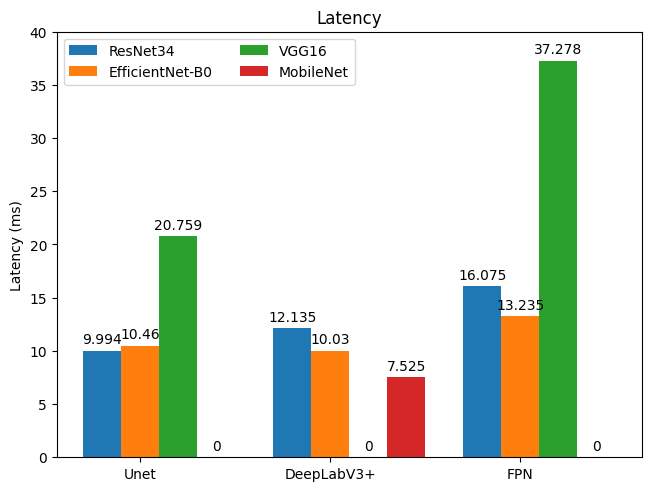

In [25]:
import matplotlib.pyplot as plt
import numpy as np

species = ("Adelie", "Chinstrap", "Gentoo")
penguin_means = {
    'Bill Depth': (18.35, 18.43, 14.98),
    'Bill Length': (38.79, 48.83, 47.50),
    'Flipper Length': (189.95, 195.82, 217.19),
}

species = ("Unet", "DeepLabV3+", "FPN")
penguin_means = {
    'ResNet34': (9.994, 12.135, 16.075),
    'EfficientNet-B0': (10.460, 10.030, 13.235),
    'VGG16': (20.759, 0, 37.278),
    'MobileNet': (0, 7.525, 0),
}

x = np.arange(len(species))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Latency (ms)')
ax.set_title('Latency')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=2)
ax.set_ylim(0, 40)

plt.show()

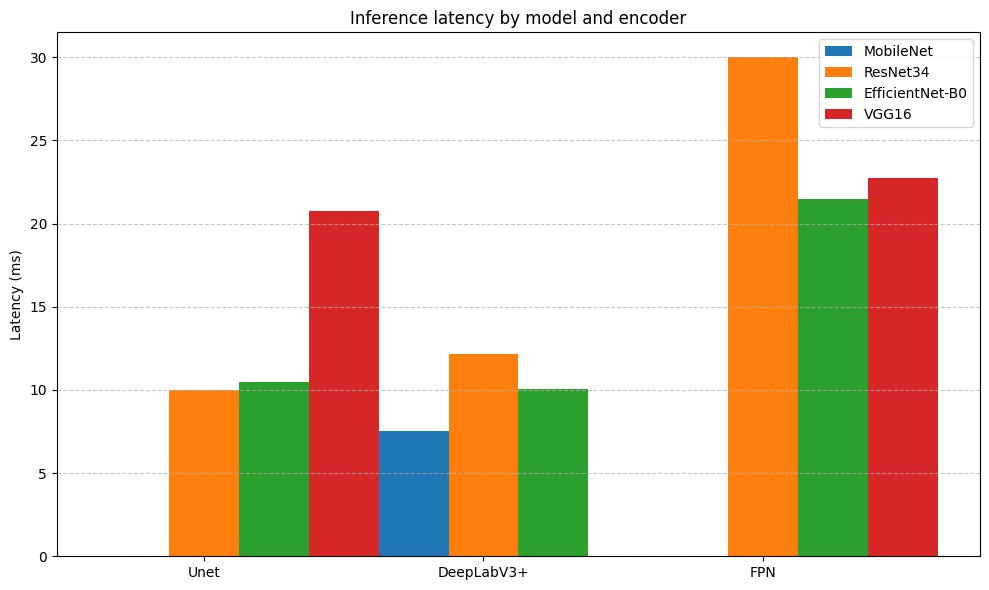

In [20]:
import matplotlib.pyplot as plt
import numpy as np

model_names = list(results.keys())
# Получаем уникальные имена энкодеров во всех моделях
encoder_names = list({enc for model in results.values() for enc in model.keys()})

num_models = len(model_names)
num_encoders = len(encoder_names)

bar_width = 0.25
x = np.arange(num_models)

plt.figure(figsize=(10, 6))

for i, enc in enumerate(encoder_names):
    latencies = [
        results[model].get(enc, 0)  # если энкодер отсутствует в модели, ставим 0
        for model in model_names
    ]
    plt.bar(x + i * bar_width, latencies, bar_width, label=enc)

plt.xticks(x + bar_width, model_names)
plt.ylabel("Latency (ms)")
plt.title("Inference latency by model and encoder")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

species = ("Unet", "DeepLabV3+", "FPN")
penguin_means = {
    'ResNet34': (18.35, 18.43, 14.98),
    'EfficientNet-B0': (38.79, 48.83, 47.50),
    'Flipper Length': (189.95, 195.82, 217.19),
}

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Length (mm)')
ax.set_title('Penguin attributes by species')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 250)

plt.show()

In [ ]:
img, mask = test_img.to(device), test_mask.to(device)

pred = model(img)
loss = dice_loss(pred, mask)

optimizer.zero_grad()
loss.backward()
optimizer.step()

In [85]:
test_img, test_mask = val_ds[1]
print(np.shape(test_img))
print(np.shape(test_mask))

torch.Size([3, 256, 256])
torch.Size([1, 256, 256])


In [88]:
test_img, test_mask = val_ds[1]
print(np.shape(test_img))
print(np.shape(test_mask))

torch.Size([3, 256, 256])
torch.Size([1, 256, 256])


In [76]:
test_img = test_img.unsqueeze(0)
test_mask = test_mask.unsqueeze(0)

In [70]:
np.shape(test_img)

torch.Size([3, 256, 256])

In [77]:
np.shape(models['unet_efficientnet'](test_img.to(device)))

torch.Size([1, 1, 256, 256])

In [55]:
models['unet_efficientnet'](test_img.to(device))

tensor([[[[ -9.5178, -14.2734, -13.9914,  ..., -15.3512, -15.4249, -10.6754],
          [-14.5501, -21.1323, -20.5763,  ..., -22.6636, -22.7025, -15.7638],
          [-14.1016, -20.6377, -20.2240,  ..., -22.0153, -22.1769, -15.4631],
          ...,
          [ -9.0592, -13.0370, -13.0744,  ..., -12.9975, -13.0134,  -9.1096],
          [ -9.8067, -13.9601, -13.5958,  ..., -13.7198, -14.1978,  -9.7834],
          [ -5.8450,  -8.8096,  -8.2002,  ...,  -8.4103,  -8.6124,  -6.6002]]]],
       device='cuda:0', grad_fn=<ConvolutionBackward0>)

In [49]:
np.shape(test_mask.int())

torch.Size([1, 256, 256])

In [78]:
test_img, test_mask = test_img.to(device), test_mask.to(device)

pred = models['unet_efficientnet'](test_img)
loss = dice_loss(pred, test_mask)

tp, fp, fn, tn = smp.metrics.get_stats(pred, test_mask.int(), mode='binary', threshold=0.5)
iou = iou_score(tp, fp, fn, tn, reduction="micro")
dice = f1_score(tp, fp, fn, tn, reduction="micro")

print(loss.item())
print(iou.item())
print(dice.item())

0.0
0.0
0.0


In [23]:
test_img, test_mask = test_img.to(device), test_mask.to(device)

pred = models['unet_resnet34'](test_img)
loss = dice_loss(pred, test_mask)


tp, fp, fn, tn = smp.metrics.get_stats(pred, test_mask.int(), mode='binary', threshold=0.5)
iou = iou_score(tp, fp, fn, tn, reduction="micro")
dice = f1_score(tp, fp, fn, tn, reduction="micro")

print(loss.item())
print(iou.item())
print(dice.item())

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [ ]:
np.shape(pred_bin)

In [ ]:
torch.rand([10, 3, 256, 256])